In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [4]:
# Read pre-processed data
save_file = 'data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


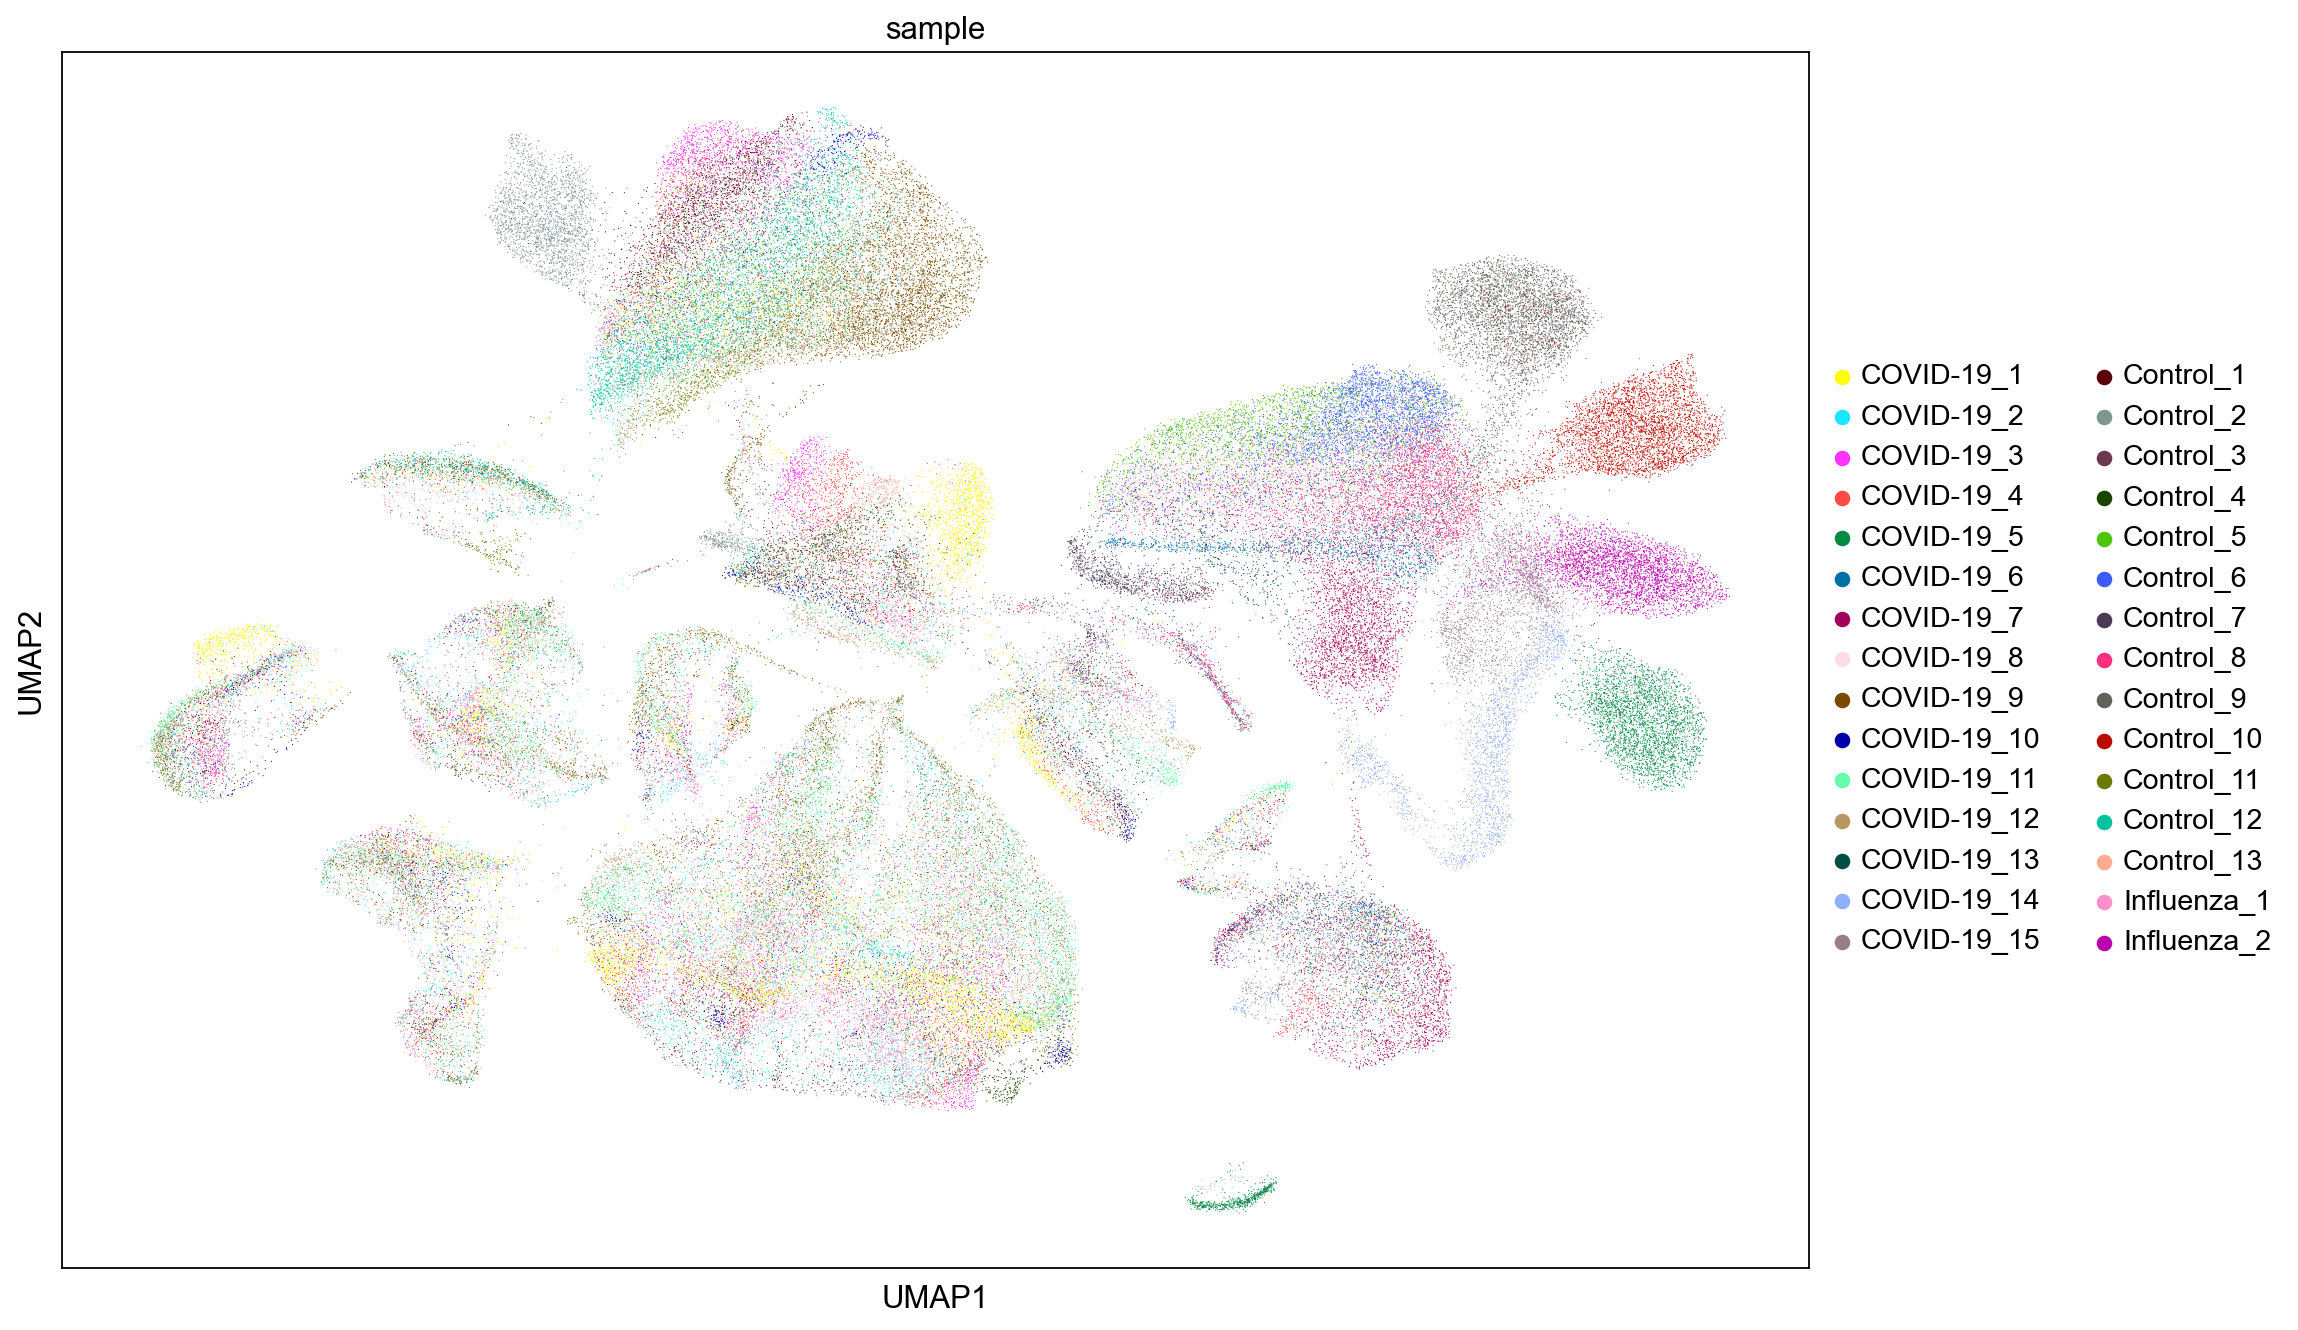

In [9]:
sc.pl.umap(adata, color='sample')

### Get centroids of each samples

In [6]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

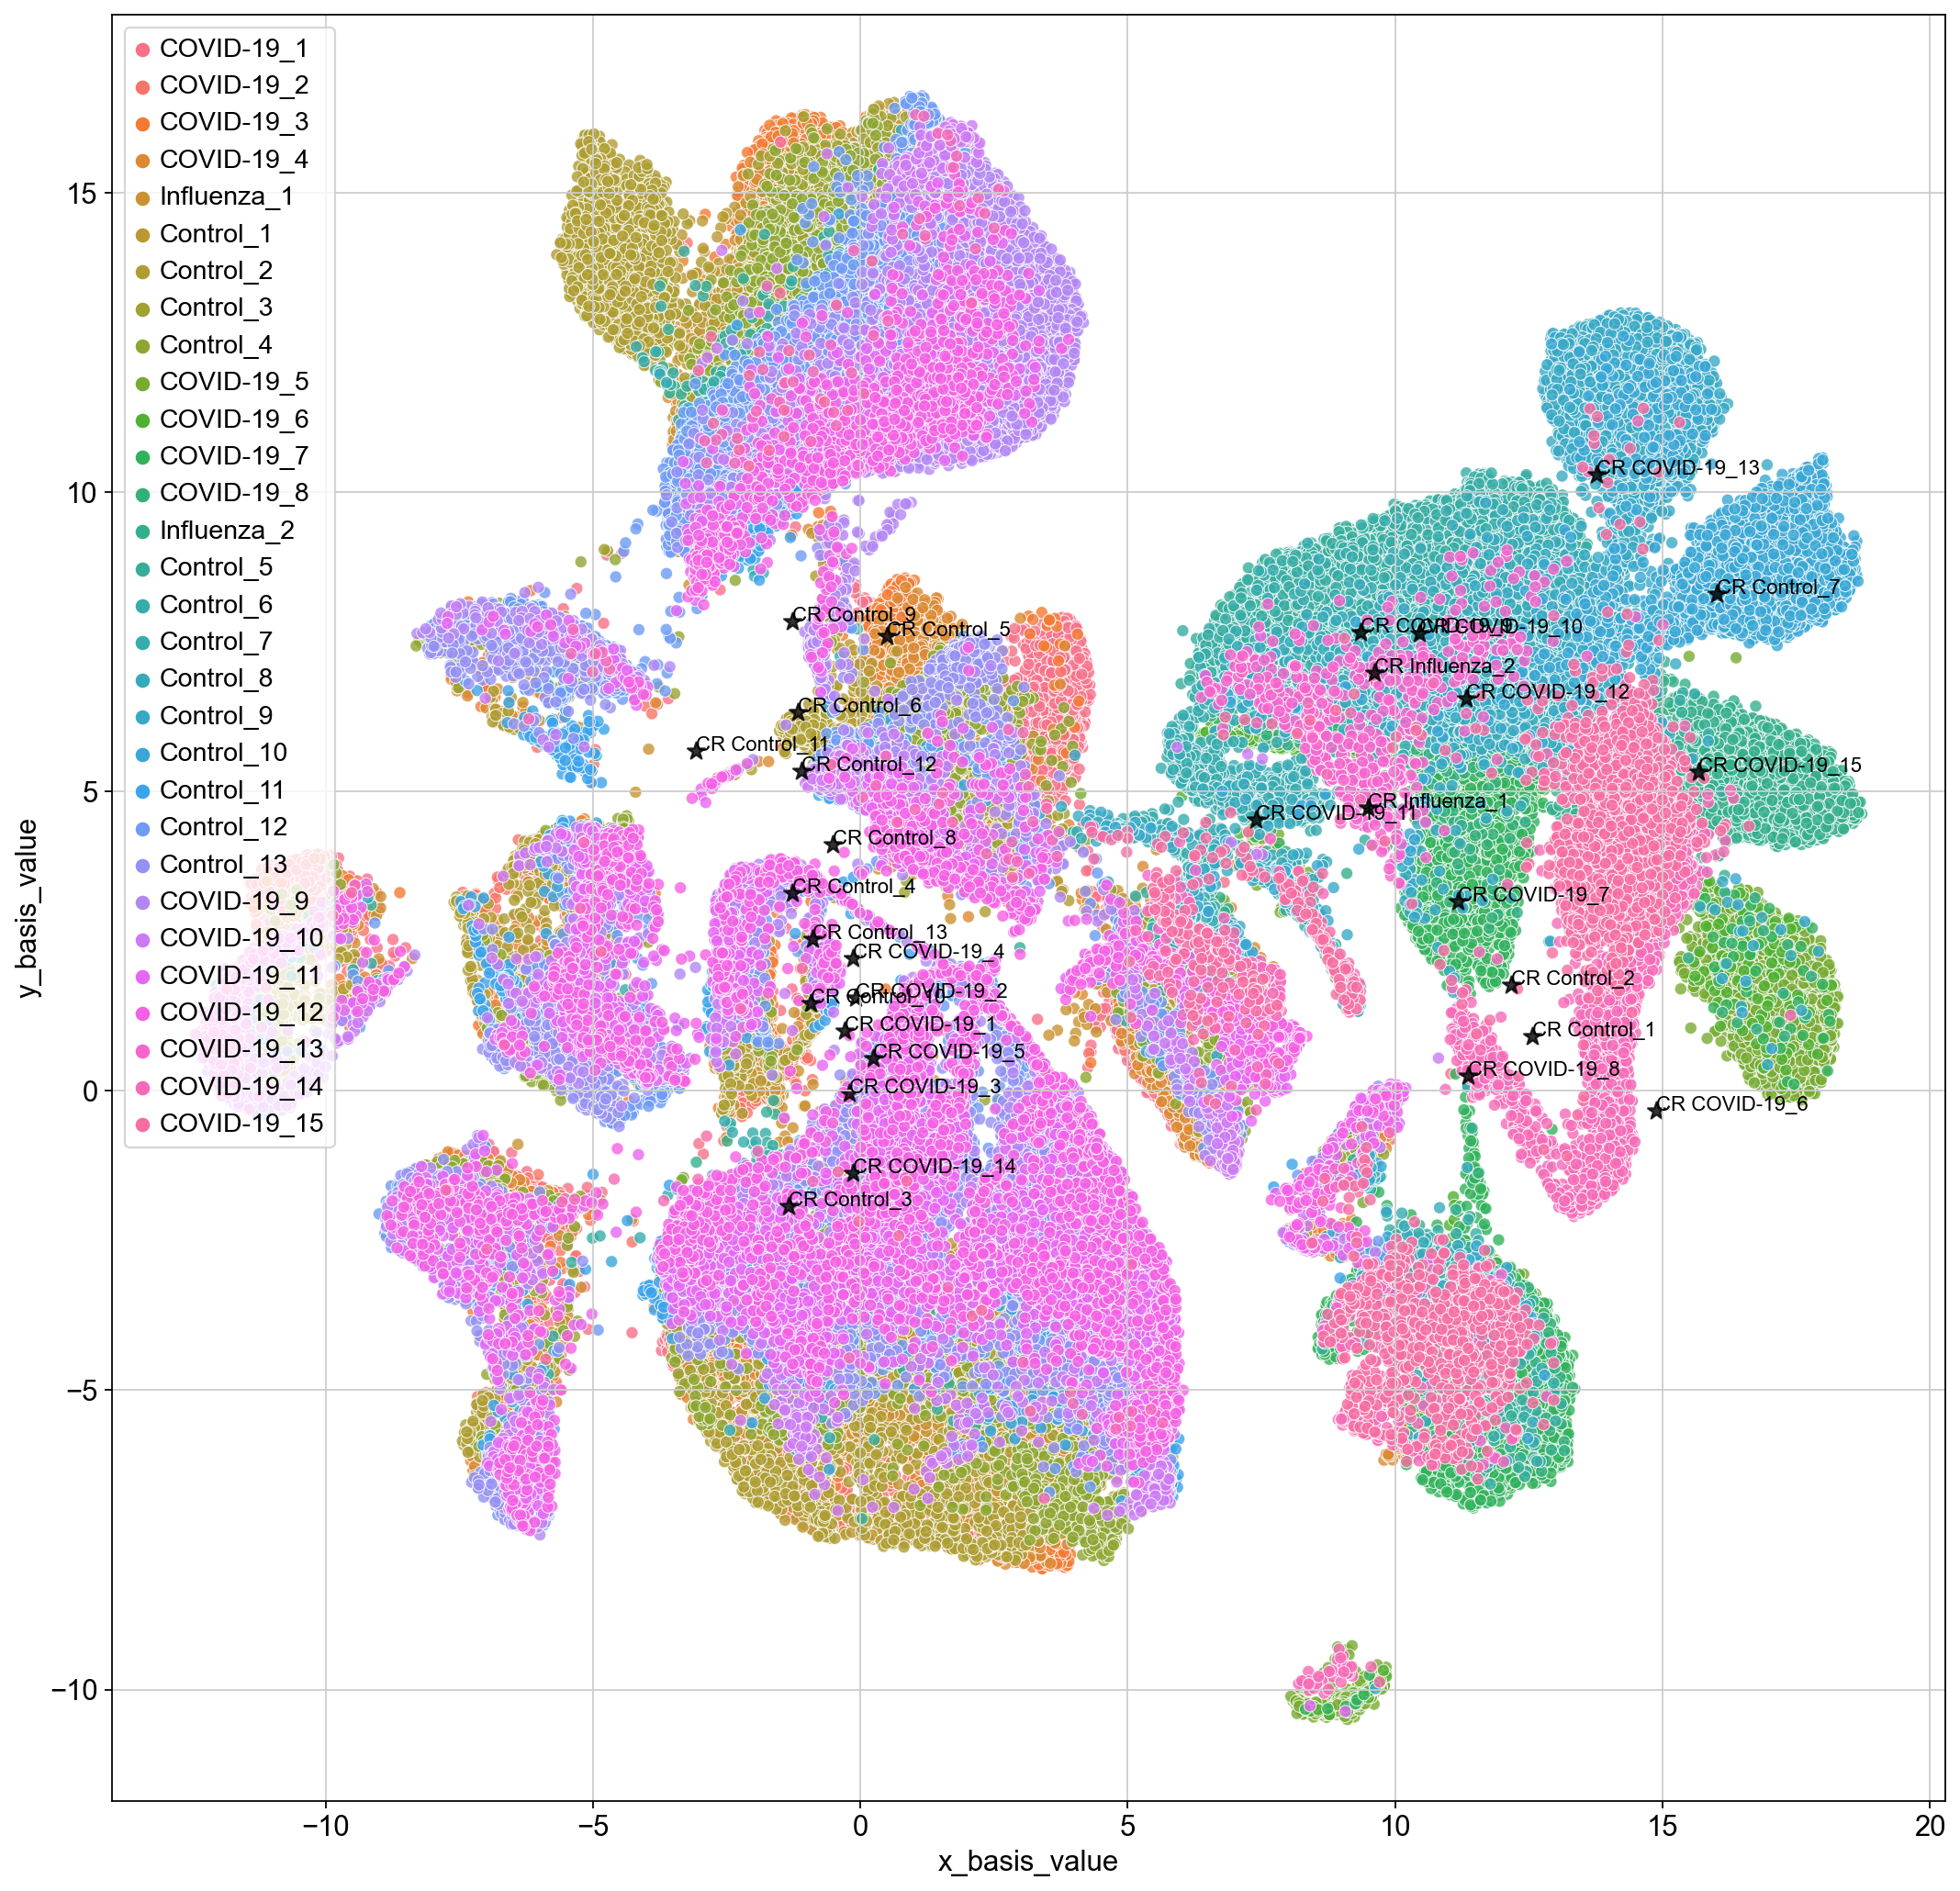

In [13]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(16, 16))
plt.legend(loc="upper left")
plt.show()

## Sample Classification: Scenario 2.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, count the nearest centroids of each cell in a new sample. And make a result based on the count (either `covid` or `non_covid`)

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [17]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7777)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_13' 'COVID-19_1' 'Control_9' 'COVID-19_11' 'COVID-19_3'
 'COVID-19_15' 'Control_5' 'COVID-19_12' 'Control_6' 'Control_3'
 'COVID-19_2' 'Control_13' 'COVID-19_6' 'COVID-19_8' 'Influenza_1'
 'Control_1' 'COVID-19_7' 'Control_12' 'Control_4' 'Control_10'
 'COVID-19_10' 'COVID-19_5' 'Control_7' 'Control_2']
Samples for testing: ['Influenza_2' 'COVID-19_9' 'COVID-19_14' 'Control_8' 'COVID-19_4'
 'Control_11']


In [18]:
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
#df_exist

Get centroids of each existing samples.

In [19]:
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid()

Get the nearest centroids with new samples.

In [20]:
y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

Count how many the nearest centroids of covid sample/non-covid samples has the new sample obtained.

In [21]:
from collections import Counter

beginning = 0
samples_range = dict()

y_pred_agg = []
y_true_agg = []
for sample in df_new['sample'].unique():
    # Assing a new label (either covid or non_covid sample))
    if 'covid' in sample or 'COVID' in sample: 
        y_true_agg.append('covid')
    else:
        y_true_agg.append('non_covid')
    samples_range[sample] = [beginning, beginning+len(df_new[df_new['sample'] == sample].index.to_list())]
    beginning = len(df_new[df_new['sample'] == sample].index.to_list())+beginning


# Get count of each new samples
for s, r in samples_range.items():
    print(f"Testing {s}")
    tmp_y_pred = y_pred[r[0]:r[1]]
    # count_detected_samples_key = list(Counter(tmp_y_pred).keys())
    # count_detected_samples = list(Counter(tmp_y_pred).values())
    count_pred_samples = Counter(tmp_y_pred)

    covid_sample_counter = 0
    non_covid_sample_counter = 0
    for s, count in count_pred_samples.items():
        if 'covid' in s or 'COVID' in s:
            covid_sample_counter+=count
        else:
            non_covid_sample_counter+=count
    
    if covid_sample_counter>non_covid_sample_counter:
        y_pred_agg.append('covid')
    else:
        y_pred_agg.append('non_covid')

Testing COVID-19_4
Testing Influenza_2
Testing Control_8
Testing Control_11
Testing COVID-19_9
Testing COVID-19_14


In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_agg, y_pred_agg))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_agg, y_pred_agg,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_agg, y_pred_agg, average='micro'))

Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666


## Sample Classification: Scenario 2.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids and then get distances between those existing samples and new samples. Then, sum the distances to the centroid of each new sample and the centroid of coronal and non-corona existing samples, separately for corona and non-corona. <br>
In the end, determine either the new sample is `covid` or `non_covid` based on the total distance with respect to covid and non-covid samples.

In [23]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

Calculate distance between new sample's centroids and exisitng one

In [24]:
print(exist_sample_centroids)
print()
print(new_sample_centroids)

[[-0.29601854  1.00610697]
 [-0.09507965  1.548473  ]
 [-0.21785446 -0.04590756]
 [-0.14094746  2.21475482]
 [ 9.48320293  4.72126055]
 [12.17519379  1.77411938]
 [-1.34918702 -1.92863452]
 [-1.26933289  3.30747581]
 [14.87887192 -0.33384344]
 [11.18094921  3.16518092]
 [11.3679266   0.25153381]
 [ 9.61826801  6.97734928]
 [-1.17063046  6.32513714]
 [16.0086174   8.29377747]
 [-1.27040982  7.84799957]
 [-0.93218416  1.45615423]
 [-3.07644534  5.67572641]
 [-1.10432529  5.34172535]
 [-0.90474242  2.53680801]
 [ 9.35632896  7.66343927]
 [10.4486227   7.63726282]
 [ 7.39251423  4.53427219]
 [13.77045822 10.2873373 ]
 [-0.14326762 -1.3670758 ]]

[[12.56449127  0.91710824]
 [ 0.24003381  0.54670334]
 [ 0.48856077  7.5945673 ]
 [-0.51233375  4.12198448]
 [11.32309151  6.54566288]
 [15.67609692  5.31898689]]


In [25]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()

list_new_sample = df_new['sample'].unique()
# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: COVID-19_1
sample: COVID-19_4
12.86081775863292
sample: Influenza_2
0.705977207065619
sample: Control_8
6.635011240274228
sample: Control_11
3.123377166120213
sample: COVID-19_9
12.872078229750999
sample: COVID-19_14
16.54416529710637
---------------------
Exist sample: COVID-19_2
sample: COVID-19_4
12.675305017180865
sample: Influenza_2
1.05633492817096
sample: Control_8
6.074198909702065
sample: Control_11
2.607117629226011
sample: COVID-19_9
12.463809175292559
sample: COVID-19_14
16.215633973169467
---------------------
Exist sample: COVID-19_3
sample: COVID-19_4
12.818570970355909
sample: Influenza_2
0.7488987525314691
sample: Control_8
7.673061879203373
sample: Control_11
4.178282202643506
sample: COVID-19_9
13.290682248214617
sample: COVID-19_14
16.774974895066656
---------------------
Exist sample: Influenza_1
sample: COVID-19_4
12.771533191151534
sample: Influenza_2
1.711006273954888
sample: Control_8
5.41651760058152
sample: Control_11
1.943

Get a label from checking the total distance of summing up the distance of exist covid sample and non covid sample between each ewn sample. <br>
<br>
And if the total distance to centroid with corona patient < the total distance to centroid with non corona patient<br>
-> The new sample is Corona (because the centroid of the new sample should be closer with the existing covid samples).<br>
Otherwise, The new sample is Non-covid.

In [26]:
covid_dist_total = 0
non_covid_dist_total = 0


new_dist_total = {s: {'covid': 0, 'non_covid': 0} for s in list_new_sample}

for i in range(len(list_exist_sample)):
    exist_sample = list_exist_sample[i]
    for new_s in dict_dist_results.keys():
        dist = dict_dist_results[new_s][i]
        if 'covid' in exist_sample or 'COVID' in exist_sample:
             new_dist_total[new_s]['covid'] += dist
        else:
            new_dist_total[new_s]['non_covid'] += dist

y_true_total_dist = []
y_pred_total_dist = []

for new_s, dist_total in new_dist_total.items():
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_total_dist.append('covid')
    else:
        y_true_total_dist.append('non_covid')

    # Compare the total distance to centroid with corona & non corona samples    
    if dist_total['covid'] < dist_total['non_covid']:
        y_pred_total_dist.append('covid')
    else:
        y_pred_total_dist.append('non_covid')

Get Acc, precision, recall, and f1 score.

In [27]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_total_dist, y_pred_total_dist))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_total_dist, y_pred_total_dist,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_total_dist, y_pred_total_dist, average='micro'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


## Sample Classification: Scenario 2.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get the nearest centroids and determine either the new sample is `covid` or `non_covid` based on the nearest sample's centroid.

In [29]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

In [30]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()
list_new_sample = df_new['sample'].unique()

# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: COVID-19_1
sample: COVID-19_4
12.86081775863292
sample: Influenza_2
0.705977207065619
sample: Control_8
6.635011240274228
sample: Control_11
3.123377166120213
sample: COVID-19_9
12.872078229750999
sample: COVID-19_14
16.54416529710637
---------------------
Exist sample: COVID-19_2
sample: COVID-19_4
12.675305017180865
sample: Influenza_2
1.05633492817096
sample: Control_8
6.074198909702065
sample: Control_11
2.607117629226011
sample: COVID-19_9
12.463809175292559
sample: COVID-19_14
16.215633973169467
---------------------
Exist sample: COVID-19_3
sample: COVID-19_4
12.818570970355909
sample: Influenza_2
0.7488987525314691
sample: Control_8
7.673061879203373
sample: Control_11
4.178282202643506
sample: COVID-19_9
13.290682248214617
sample: COVID-19_14
16.774974895066656
---------------------
Exist sample: Influenza_1
sample: COVID-19_4
12.771533191151534
sample: Influenza_2
1.711006273954888
sample: Control_8
5.41651760058152
sample: Control_11
1.943

In [36]:
dict_nearest_dist_idex = dict()
y_true_nearest = []
y_pred_nearest = []

for new_s, coords_centroid in dict_dist_results.items():
    nearest_sample_index = np.argmin(np.array(coords_centroid))
    nearest_sample = list_exist_sample[nearest_sample_index]

    # Assign a label to y_true
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_nearest.append('covid')
    else:
        y_true_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the nearest sample by distance
    if 'covid' in nearest_sample or 'COVID' in nearest_sample:
        y_pred_nearest.append('covid')
    else:
        y_pred_nearest.append('non_covid')


In [51]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_nearest, y_pred_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_nearest, y_pred_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_nearest, y_pred_nearest, average='micro'))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5


## Sample Classification: Scenario 3.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Run kmeans clusterning and get clusters as well as a centroid of covid and non_covid. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [52]:
umap1 = adata.obsm['X_umap'][:, 0]
umap2 = adata.obsm['X_umap'][:, 1]
sample_vector = adata.obs['sample'].values

df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
               columns =['umap1', 'umap2', 'sample'])
df

umap1     umap2       sample
0        1.939955 -4.752501   COVID-19_1
1      -11.327367  3.537616   COVID-19_1
2       -1.533164 -3.437606   COVID-19_1
3        4.854027  1.345688   COVID-19_1
4       -3.259794 -4.839449   COVID-19_1
...           ...       ...          ...
114696  14.855623  2.865599  COVID-19_15
114697  11.101423 -3.691802  COVID-19_15
114698  13.821174  4.935024  COVID-19_15
114699  13.454780  3.591425  COVID-19_15
114700   9.943240 -4.885163  COVID-19_15

[114701 rows x 3 columns]

In [53]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if 'covid' in row['sample'] or 'COVID' in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

umap1     umap2       sample covid_non_covid
0        1.939955 -4.752501   COVID-19_1           covid
1      -11.327367  3.537616   COVID-19_1           covid
2       -1.533164 -3.437606   COVID-19_1           covid
3        4.854027  1.345688   COVID-19_1           covid
4       -3.259794 -4.839449   COVID-19_1           covid
...           ...       ...          ...             ...
114696  14.855623  2.865599  COVID-19_15           covid
114697  11.101423 -3.691802  COVID-19_15           covid
114698  13.821174  4.935024  COVID-19_15           covid
114699  13.454780  3.591425  COVID-19_15           covid
114700   9.943240 -4.885163  COVID-19_15           covid

[114701 rows x 4 columns]

#### Split the dataset into train: df_exist and test: df_new

In [58]:
list_samples = df['sample'].unique()

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=111)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Influenza_1' 'Control_7' 'Influenza_2' 'Control_2' 'Control_1'
 'COVID-19_11' 'Control_8' 'COVID-19_12' 'COVID-19_1' 'COVID-19_2'
 'COVID-19_6' 'COVID-19_14' 'COVID-19_10' 'Control_3' 'Control_4'
 'Control_9' 'COVID-19_3' 'COVID-19_5' 'Control_10' 'Control_13'
 'COVID-19_13' 'COVID-19_15' 'COVID-19_8' 'Control_11']
Samples for testing: ['Control_12' 'Control_5' 'COVID-19_4' 'Control_6' 'COVID-19_9'
 'COVID-19_7']


In [59]:
# Make a dataframe for training
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
df_exist

umap1     umap2       sample covid_non_covid
0        1.939955 -4.752501   COVID-19_1           covid
1      -11.327367  3.537616   COVID-19_1           covid
2       -1.533164 -3.437606   COVID-19_1           covid
3        4.854027  1.345688   COVID-19_1           covid
4       -3.259794 -4.839449   COVID-19_1           covid
...           ...       ...          ...             ...
114696  14.855623  2.865599  COVID-19_15           covid
114697  11.101423 -3.691802  COVID-19_15           covid
114698  13.821174  4.935024  COVID-19_15           covid
114699  13.454780  3.591425  COVID-19_15           covid
114700   9.943240 -4.885163  COVID-19_15           covid

[85011 rows x 4 columns]

In [60]:
# Make a dataframe for testing
y_test = list(y_test)
df_new = df.query("sample == @y_test")
df_new

umap1      umap2      sample covid_non_covid
14893  2.747445   3.154681  COVID-19_4           covid
14894 -1.162378  -4.825221  COVID-19_4           covid
14895 -5.715297   0.878239  COVID-19_4           covid
14896  7.384730   2.150717  COVID-19_4           covid
14897  0.349497   7.849064  COVID-19_4           covid
...         ...        ...         ...             ...
95966  3.326286  13.175691  COVID-19_9           covid
95967  3.027990  14.481750  COVID-19_9           covid
95968  0.096695   5.370456  COVID-19_9           covid
95969 -6.019488   7.665164  COVID-19_9           covid
95970 -1.104173   3.693245  COVID-19_9           covid

[29690 rows x 4 columns]

### Run Kmeans clusterning to get clusters' centroids as a cluster representation.

Also, check the elbow to determine the number of clusters (the parameter `k`).

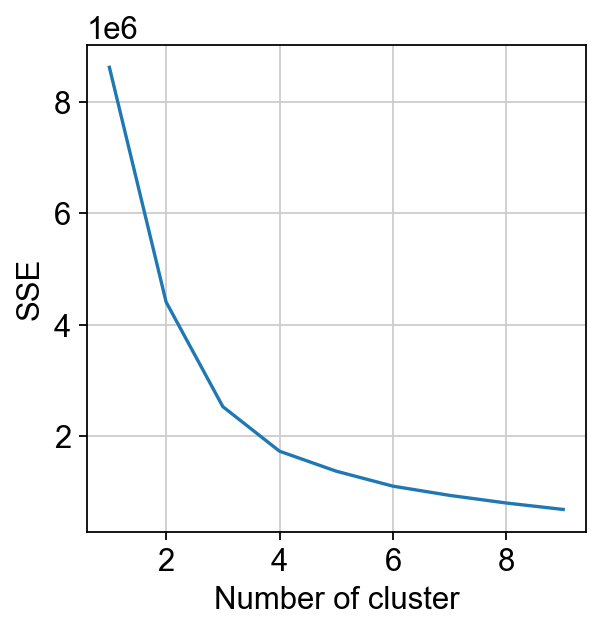

In [62]:
from sklearn.cluster import KMeans
sc.set_figure_params(figsize=None)

data = (df_exist[['umap1', 'umap2']])
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

According to the above plot, we shall use `k=3` this time.<br>
<br>

Next, train a kmeans again with `k=3`, and get distances between each centroid and each sample, and then append them to the dataframe.

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_38085/4207277840.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_38085/4207277840.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_38085/4207277840.py:19: SettingWithCopyWarning: 
A value is trying to be se

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_1'>

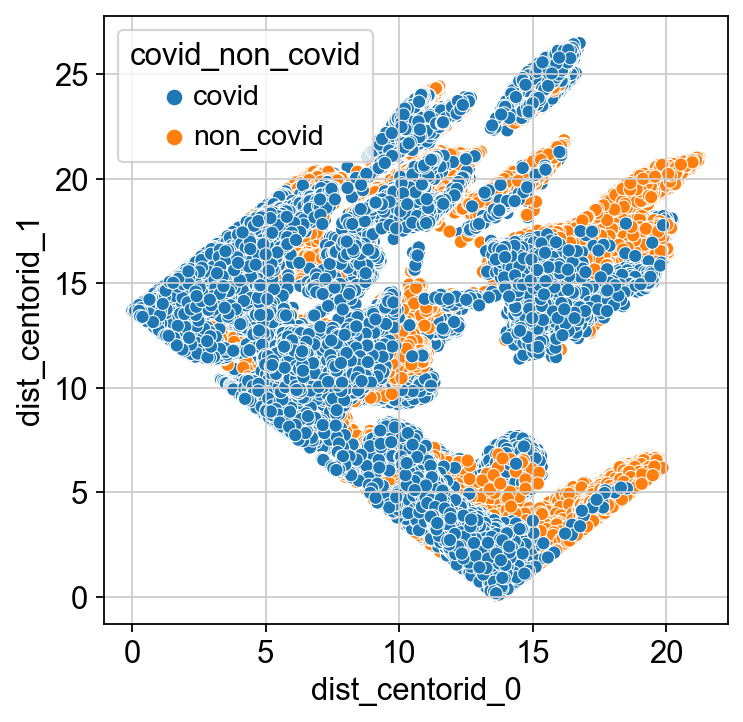

In [63]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

### Compute a distance
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

Also, print the augmented dataframe.

In [66]:
df_exist

umap1     umap2       sample covid_non_covid  dist_centorid_0  \
0        1.939955 -4.752501   COVID-19_1           covid         2.320365   
1      -11.327367  3.537616   COVID-19_1           covid        16.582535   
2       -1.533164 -3.437606   COVID-19_1           covid         5.303146   
3        4.854027  1.345688   COVID-19_1           covid         4.794511   
4       -3.259794 -4.839449   COVID-19_1           covid         7.190005   
...           ...       ...          ...             ...              ...   
114696  14.855623  2.865599  COVID-19_15           covid        12.697800   
114697  11.101423 -3.691802  COVID-19_15           covid         7.341850   
114698  13.821174  4.935024  COVID-19_15           covid        13.010325   
114699  13.454780  3.591425  COVID-19_15           covid        11.901560   
114700   9.943240 -4.885163  COVID-19_15           covid         6.368679   

        dist_centorid_1  dist_centorid_2  dist_centorid_3  
0             16.003387        15.697396         9.160767  
1             24.990468        12.730271         6.492240  
2             17.921697        14.159338         5.535021  
3              9.975238        10.935523        10.913639  
4             20.134380        15.735092         5.440838  
...                 ...              ...              ...  
114696         3.692883        17.512418        21.029356  
114697        10.282142        18.680925        17.433160  
114698         1.404390        15.722562        20.417186  
114699         2.713512        15.934873        19.766889  
114700        11.744105        18.934594        16.603923  

[85011 rows x 8 columns]

Train the augmented dataset in SVM

In [67]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

Print the dataframe for the test data/new samples

In [68]:
df_new

umap1      umap2      sample covid_non_covid
14893  2.747445   3.154681  COVID-19_4           covid
14894 -1.162378  -4.825221  COVID-19_4           covid
14895 -5.715297   0.878239  COVID-19_4           covid
14896  7.384730   2.150717  COVID-19_4           covid
14897  0.349497   7.849064  COVID-19_4           covid
...         ...        ...         ...             ...
95966  3.326286  13.175691  COVID-19_9           covid
95967  3.027990  14.481750  COVID-19_9           covid
95968  0.096695   5.370456  COVID-19_9           covid
95969 -6.019488   7.665164  COVID-19_9           covid
95970 -1.104173   3.693245  COVID-19_9           covid

[29690 rows x 4 columns]

In [ ]:
# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred


In [70]:
df_new

umap1      umap2      sample covid_non_covid  dist_centorid_0  \
14893  2.747445   3.154681  COVID-19_4           covid         6.559069   
14894 -1.162378  -4.825221  COVID-19_4           covid         5.154489   
14895 -5.715297   0.878239  COVID-19_4           covid        10.373505   
14896  7.384730   2.150717  COVID-19_4           covid         6.561392   
14897  0.349497   7.849064  COVID-19_4           covid        11.684920   
...         ...        ...         ...             ...              ...   
95966  3.326286  13.175691  COVID-19_9           covid        16.506006   
95967  3.027990  14.481750  COVID-19_9           covid        17.821536   
95968  0.096695   5.370456  COVID-19_9           covid         9.438452   
95969 -6.019488   7.665164  COVID-19_9           covid        14.716665   
95970 -1.104173   3.693245  COVID-19_9           covid         8.543576   

       dist_centorid_1  dist_centorid_2  dist_centorid_3     y_pred  
14893        11.213466         8.342548         9.302792      covid  
14894        18.415517        15.532333         6.723066      covid  
14895        19.975853        10.983421         1.024800      covid  
14896         7.400365        11.841273        13.537160      covid  
14897        13.250318         3.078666        10.162531      covid  
...                ...              ...              ...        ...  
95966        12.284627         4.814868        16.215516      covid  
95967        13.294011         5.382554        17.144037      covid  
95968        13.445250         5.408271         8.173501      covid  
95969        19.576310         6.034715         7.782004  non_covid  
95970        14.845087         7.016134         6.172990      covid  

[29690 rows x 9 columns]

In [71]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if 'covid' in sample or 'COVID' in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'COVID-19_4': [3892, 669], 'COVID-19_7': [4922, 97], 'Control_5': [1975, 510], 'Control_6': [2249, 1745], 'Control_12': [2676, 4130], 'COVID-19_9': [5870, 955]}


In [72]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666


## Sample Classification: Scenario 3.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification
